# Adding features to Human DNASU Data

## Loading packages

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
from mpl_toolkits import mplot3d
np.set_printoptions(threshold=sys.maxsize)
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import statistics
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import mannwhitneyu, fisher_exact
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm
from statsmodels.stats.multitest import fdrcorrection

## Merging Human Features with DNASU Human proteins, Expression data and LHP Pred and splitting into train, test and validate

In [75]:
df = pd.read_csv("DNASU_HUMAN.csv", sep=',', index_col=0)
DNASU = df.copy()
features = pd.read_csv("features_human_proteome_no_filtering.csv")
features.rename(columns = {'id':'UniprotID'}, inplace = True)
features= features.drop(['A', 'C', 'D', 'E','F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T','V', 'W', 'Y','Aromaticity', 'Instability_index','charge_at_7'], axis=1)
# features.columns.values
df = df.merge(features, on='UniprotID', how='left')
pd.set_option('display.max_rows', 500)
LP_pred = pd.read_csv("LHP_PREDICTIONS.tsv", sep='\t')
LP_pred.rename(columns = {'id':'UniprotID', 'prediction':'LHPpred'}, inplace = True)
df = df.merge(LP_pred, on='UniprotID', how='left')
Expression = pd.read_csv('ExpressionGenesAndUniprot.csv', index_col=0)
max_exp = Expression.groupby(['Gene','Gene_name', 'Uniprot_ID']).agg({'Tissue': lambda x: ",".join(x), 'NX':'max'}).rename({'NX' : 'max_NX'},axis=1).reset_index()
max_exp.rename(columns = {'Uniprot_ID':'UniprotID'}, inplace = True)
max_exp = max_exp.drop(["Tissue","Gene_name", "Gene"],axis=1 )
df = df.merge(max_exp, on='UniprotID', how='left')
df = df.select_dtypes(['number'])
original = df
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
original.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
new_df = df

In [76]:
len(new_df)
sum(DNASU["Binary_Solubility"])

1495

## Correlation plots 

### LHP pred vs Solubility 

p = 0.000000
skewness = 4.770180
kurtosis = 31.320817


[Text(0, 0, 'Soluble'), Text(1, 0, 'Non-Soluble')]

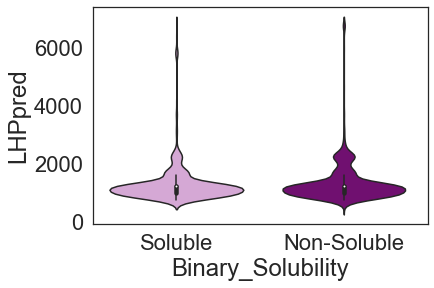

In [77]:
k2, p = stats.normaltest(df["LHPpred"], nan_policy = "omit")
print("p = {:f}".format(p))
print("skewness = {:f}".format(skew(df["LHPpred"], nan_policy = "omit")))
print("kurtosis = {:f}".format(kurtosis(df["LHPpred"], nan_policy = "omit")))
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_Solubility', y="LHPpred", data=df, palette=my_pal, showmeans=True, )
ax.set_xticklabels(["Soluble",'Non-Soluble'])

Text(0.5, 0, 'LHP predictions')

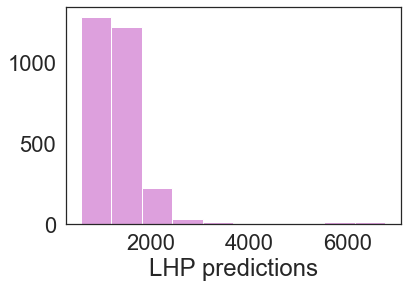

In [78]:
plt.hist(df["LHPpred"], color = "plum")
plt.xlabel("LHP predictions")

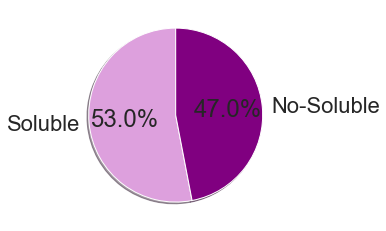

In [79]:
part = np.array((df["Binary_Solubility"].sum()/(len(df["Binary_Solubility"])), 1- (df["Binary_Solubility"].sum()/(len(df["Binary_Solubility"])))))
labels = ["Soluble", "No-Soluble"]
colors = ["plum", "purple"]
plt.pie(part, labels= labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

### Expression vs Solubility 

p = 0.000000
skewness = 6.564983
kurtosis = 65.708477


[Text(0, 0, 'Soluble'), Text(1, 0, 'Non-Soluble')]

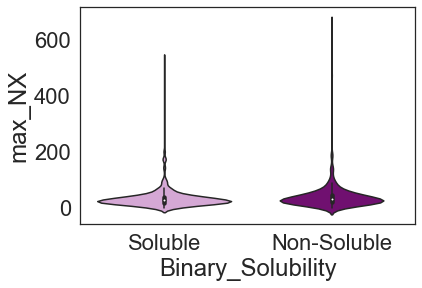

In [80]:
k2, p = stats.normaltest(df['max_NX'], nan_policy = "omit")
print("p = {:f}".format(p))
print("skewness = {:f}".format(skew(df['max_NX'], nan_policy = "omit")))
print("kurtosis = {:f}".format(kurtosis(df['max_NX'], nan_policy = "omit")))
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_Solubility', y='max_NX', data=df, palette=my_pal)
ax.set_xticklabels(["Soluble",'Non-Soluble'])


Text(0.5, 0, 'Max Normalised Expression')

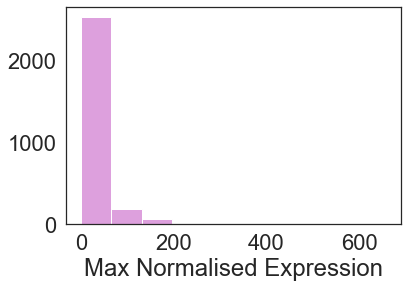

In [81]:
plt.hist(df['max_NX'], color = "plum")
plt.xlabel("Max Normalised Expression")

### 3D plot of log(max_expression), LHP predictions, Aggregation propensity and Solubility

/Users/priya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


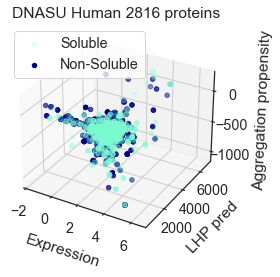

In [82]:
sns.set(style=("white"), font_scale=1.3)
marker_size=15
fig = plt.figure()
ax = plt.axes(projection='3d')
sol = df.loc[df['Binary_Solubility'] == 1]
ag = df.loc[df['Binary_Solubility'] == 0]
ax.scatter3D(np.log(sol['max_NX']) , sol['LHPpred'], sol['Aggregation_propensity'], c='aquamarine', alpha =0.2)
ax.scatter3D(np.log(ag['max_NX']) , ag['LHPpred'], ag['Aggregation_propensity'], c='navy')
ax.set_xlabel("Expression", labelpad=10)
ax.set_ylabel("LHP pred",labelpad=10)
ax.set_zlabel("Aggregation propensity",labelpad=10)
ax.legend(["Soluble", "Non-Soluble"])
ax.set_title("DNASU Human 2816 proteins")
plt.savefig('Figures/3Dplot.png', dpi=300, bbox_inches='tight')
plt.show()

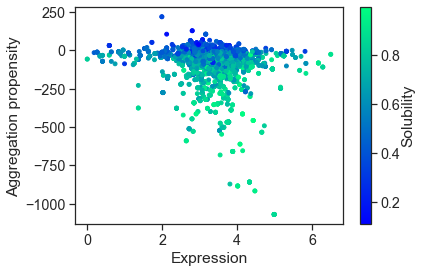

In [83]:
marker_size=15
sns.set(style=("ticks"),font_scale=1.3)
plt.scatter(np.log(df['max_NX']+1),df['Aggregation_propensity'] , marker_size, c=df['Prob. of Solubility'], cmap = "winter" )
plt.xlabel("Expression")
plt.ylabel("Aggregation propensity")
cbar= plt.colorbar()
cbar.set_label("Solubility", labelpad=+1)
plt.savefig('Figures/2Dplot.png',dpi=300, bbox_inches='tight')
plt.show()

### Correlation between Max_expression, LHP predictions, Aggregation propensity and Solubility

/var/folders/3j/bhbg34qd24553j30j22dbny40000gn/T/ipykernel_77429/3357150944.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=False, ax=ax)


Text(0.5, 1.0, 'DNASU human protein data')

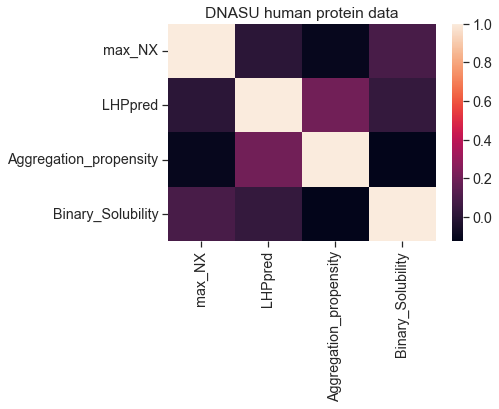

In [84]:
df_corr = df.filter(['max_NX' , 'LHPpred', 'Aggregation_propensity', 'Binary_Solubility' ],axis=1)
corr = df_corr.corr()
ax = plt.axes()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=False, ax=ax)
ax.set_title('DNASU human protein data')

## Machine learning

#### Selecting the features and scaling them

In [85]:
seq_features = ['Binary_Solubility','length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred','max_NX']

len(seq_features)

71

In [86]:
def get_normalised_df(df):
    df_min_max_scaled = df.copy()
    # apply normalization to all columns
    for column in df_min_max_scaled:
        if column != 'Binary_Solubility':
            df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
    return df_min_max_scaled


In [87]:
new_df = df[seq_features]
Final_DNASU_ML = get_normalised_df(new_df)#TRAINING DATASET


#### Splitting data into train, test and validate

In [88]:
# Final_DNASU_ML = Final_DNASU_ML.drop(["HUMAN", "GPI-anchor_UP","Prob. of Solubility"], axis = 1)
df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
df_test, df_val = train_test_split(df_test_val, test_size=0.5)
df_train =df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [89]:
x_train, x_test, y_train, y_test = train_test_split(Final_DNASU_ML.drop('Binary_Solubility', axis = 1), Final_DNASU_ML['Binary_Solubility'],test_size=0.2,random_state=0,stratify=Final_DNASU_ML['Binary_Solubility'])
# df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test,test_size=0.5,random_state=0,stratify=y_test)
df_train = pd.concat([y_train,x_train], axis =1).reset_index(drop=True)
df_test = pd.concat([y_test,x_test], axis =1).reset_index(drop=True)
df_val = pd.concat([y_validate,x_validate], axis =1).reset_index(drop=True)
df_train

,Binary_Solubility,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,Glycosylation_MSD,Ubiquitination_MSD,SUMOylation_MSD,Acetylation_MSD,Palmitoylation_MSD,Methylation_MSD,Polar_exposed,Hydrophobic_exposed,LHPpred,max_NX
0,1,0.569194,0.664935,0.471279,0.571089,0.496627,0.356679,0.261239,0.188406,0.027778,...,1.0,0.0,0.0,0.0,0.0,0.0,0.680556,0.175680,0.072305,0.025582
1,1,0.478740,0.668170,0.372165,0.473575,0.534561,0.421318,0.130195,0.028986,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.495440,0.307966,0.109560,0.021776
2,1,0.629814,0.528653,0.399274,0.628505,0.250076,0.572213,0.322306,0.159420,0.055556,...,1.0,0.0,1.0,0.0,1.0,1.0,0.467014,0.246166,0.062492,0.044922
3,0,0.369586,0.673816,0.379960,0.361710,0.355878,0.436642,0.349683,0.724638,0.194444,...,1.0,0.0,1.0,0.0,0.0,0.0,0.700680,0.140736,0.109560,0.038526
4,0,0.795553,0.746458,0.306161,0.795292,0.459708,0.348762,0.320375,0.304348,0.083333,...,1.0,0.0,0.0,1.0,0.0,1.0,0.707968,0.095074,0.050818,0.046901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,1,0.531533,0.587575,0.367780,0.520125,0.340535,0.662699,0.088991,0.086957,0.222222,...,1.0,0.0,1.0,1.0,0.0,0.0,0.351250,0.446680,0.269199,0.077052
2248,0,0.398269,0.612685,0.544185,0.402266,0.482478,0.454461,0.158503,0.057971,0.027778,...,1.0,0.0,0.0,0.0,0.0,0.0,0.843583,0.078588,0.050818,0.043094
2249,1,0.397265,0.732788,0.406523,0.394202,0.854853,0.152260,0.037252,0.057971,0.000000,...,1.0,0.0,1.0,1.0,0.0,1.0,0.716270,0.306582,0.222844,0.025887
2250,1,0.284458,0.800142,0.394164,0.282725,0.414156,0.446036,0.260196,0.275362,0.083333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.696756,0.181537,0.109560,0.059845


In [90]:
sum(df_train["Binary_Solubility"])

1194

In [16]:
#Labels are the values to be predicted, in this case the solubility
Train_labels = np.array(df_train['Binary_Solubility'])

# Remove the labels from the features
Train_features= df_train.drop('Binary_Solubility', axis = 1)

# Saving feature names for later use
Train_feature_list = list(Train_features.columns)

# Convert to numpy array
Train_features = np.array(Train_features)
# Train_features = RobustScaler().fit_transform(Train_features)


#Same thing for test set
Test_labels = np.array(df_test['Binary_Solubility'])
Test_features = df_test.drop('Binary_Solubility', axis = 1)
Test_feature_list = list(Test_features.columns)
Test_features = np.array(Test_features)
# Test_features = RobustScaler().fit_transform(Test_features)

#And the cleaned test set
Test_labels2 = np.array(df_val['Binary_Solubility'])
Test_features2 = df_val.drop('Binary_Solubility', axis = 1)
Test_feature_list2 = list(Test_features2.columns)
Test_features2 = np.array(Test_features2)
# Test_features2 = RobustScaler().fit_transform(Test_features2)

#Check shape of train and test
print('Training Features Shape:', Train_features.shape)
print('Training Labels Shape:', Train_labels.shape)
print('Testing Features Shape:', Test_features.shape)
print('Testing Labels Shape:', Test_labels.shape)
print('Cleaned testing Features Shape:', Test_features2.shape)
print('Cleaned testing Labels Shape:', Test_labels2.shape)


Training Features Shape: (2252, 70)
Training Labels Shape: (2252,)
Testing Features Shape: (282, 70)
Testing Labels Shape: (282,)
Cleaned testing Features Shape: (282, 70)
Cleaned testing Labels Shape: (282,)


## Training the Model and predicting solubility

In [17]:
Final_DNASU_ML.describe()

,Binary_Solubility,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,Glycosylation_MSD,Ubiquitination_MSD,SUMOylation_MSD,Acetylation_MSD,Palmitoylation_MSD,Methylation_MSD,Polar_exposed,Hydrophobic_exposed,LHPpred,max_NX
count,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,...,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000
mean,0.530185,0.457149,0.613793,0.453743,0.455353,0.401234,0.498306,0.212433,0.208833,0.121064,...,0.851562,0.048295,0.475852,0.282670,0.175781,0.458097,0.590796,0.291645,0.120789,0.058122
std,0.499177,0.162349,0.124095,0.109809,0.165738,0.201363,0.186513,0.159295,0.157468,0.107055,...,0.355596,0.214428,0.499505,0.450378,0.380702,0.498329,0.174088,0.139301,0.106382,0.066092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.348977,0.536778,0.380599,0.341973,0.254875,0.376323,0.096564,0.086957,0.055556,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.481427,0.194867,0.067386,0.028476
50%,1.000000,0.444149,0.627159,0.447911,0.439304,0.378928,0.478900,0.187116,0.159420,0.083333,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.608400,0.280372,0.109560,0.043551
75%,1.000000,0.544392,0.700080,0.515382,0.542034,0.525195,0.616001,0.305896,0.289855,0.166667,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.713964,0.379870,0.109560,0.065669
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
#Support vector
svc = SVC(random_state=42)
svc.fit(Train_features, Train_labels)

#random forest
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt')
rf.fit(Train_features, Train_labels)

#Logistic regression
lr = LogisticRegression(max_iter = 1000)
lr.fit(Train_features, Train_labels)

LogisticRegression(max_iter=1000)

In [19]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(Test_features)

# Probabilities for each class
rf_probs = rf.predict_proba(Test_features)[:, 1]

#same for cleaned test set
rf_predictions2 = rf.predict(Test_features2)
rf_probs2 = rf.predict_proba(Test_features2)[:, 1]

In [20]:
# Calculate roc auc 
roc_value = roc_auc_score(Test_labels, rf_probs)
print('AUC:', roc_value)

#same for cleaned
roc_value = roc_auc_score(Test_labels2, rf_probs2)
print('AUC:', roc_value)

AUC: 0.8698737373737374
AUC: 0.8989756269869303


In [21]:
def get_AUC(model, x_train, x_test, y_train, y_test):
    rf = model.fit(x_train, y_train)
    rf_predictions = rf.predict(x_test)
    rf_probs = rf.predict_proba(x_test)[:, 1]
    roc_value = roc_auc_score(y_test, rf_probs)
    return roc_value

### Feature importance 

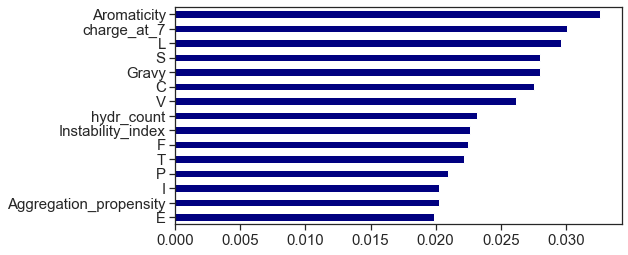

In [22]:
# Extract feature importances
fi = pd.DataFrame({'feature': (Train_feature_list),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = True)

# Display
fi
top_20 = fi[:-20]


feature_importance = pd.Series(index = df_train.drop('Binary_Solubility', axis = 1).columns.values, data = rf.feature_importances_)
feature_importance.sort_values(ascending = True)[55:].plot(kind='barh',  figsize=(8,4), color="navy", fontsize=15)
fig = plt.gcf()
plt.savefig('Figures/featureImportance.png', dpi=300, bbox_inches='tight')


# .sort_values("feature", ascending = True)

### ROC curves 

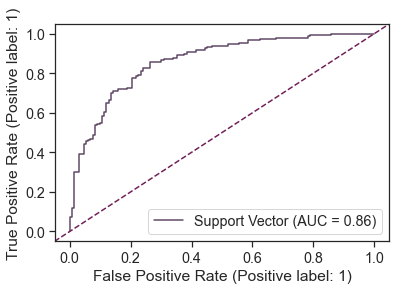

In [23]:
sns.set_palette("rocket")
ax = plt.gca()
svc_disp2 = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

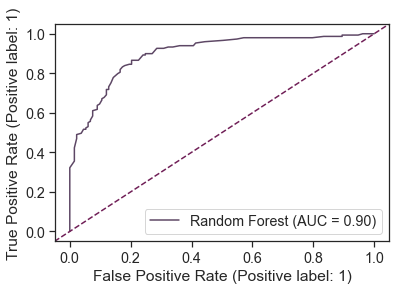

In [24]:
ax = plt.gca()
rf_disp2 = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

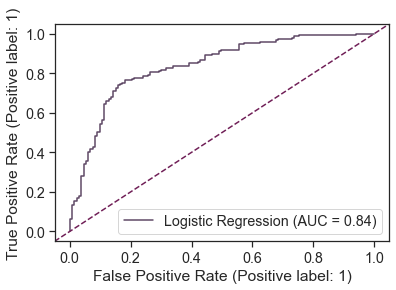

In [25]:
ax = plt.gca()
svc_disp2 = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

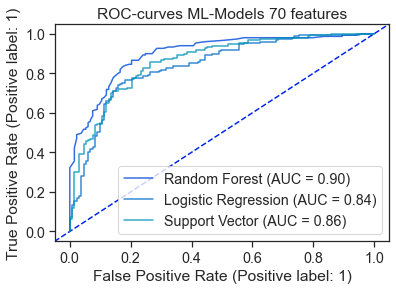

In [26]:
sns.set_palette("winter")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('ROC-curves ML-Models 70 features')
plt.savefig('Figures/ROC.png', dpi=300, bbox_inches='tight')
plt.show()

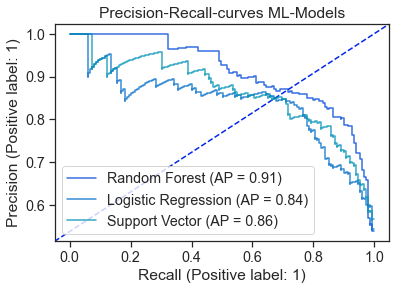

In [27]:
sns.set_palette("winter")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_precision_recall_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_precision_recall_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_precision_recall_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('Precision-Recall-curves ML-Models')
plt.savefig('Figures/PRC.png', dpi=300, bbox_inches='tight')
plt.show()

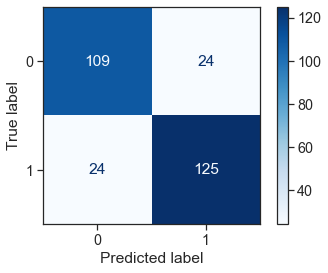

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Test_labels2,rf_predictions2)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.savefig('Figures/ConfusionMatrix.png', dpi=300, bbox_inches='tight')

In [29]:
from sklearn.metrics import f1_score, matthews_corrcoef, fowlkes_mallows_score
print(f1_score(Test_labels2,rf_predictions2))
print(matthews_corrcoef(Test_labels2,rf_predictions2))
print(fowlkes_mallows_score(Test_labels2,rf_predictions2))

0.8389261744966443
0.6584750466770954
0.7164209250656433


## Stratified 10- fold cross validation: AUC

In [30]:
from sklearn.model_selection import train_test_split
SOLtarget = np.array(df_train['Binary_Solubility'])
SOLdata = np.array(Train_features)

In [31]:
def get_score(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

In [32]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 10)

In [33]:
AUC_rf = []
for train_index,test_index in kf.split(SOLdata, SOLtarget):
    x_train, x_test, y_train, y_test = SOLdata[train_index], SOLdata[test_index], \
                                        SOLtarget[train_index], SOLtarget[test_index]
    model = LogisticRegression(max_iter = 1000)
    AUC_rf.append(get_AUC(model, x_train, x_test, y_train, y_test))
print("Mean AUC score:")
print(np.mean(AUC_rf))

Mean AUC score:
0.7432304934552436


In [34]:
print(np.mean(cross_val_score(LogisticRegression(max_iter = 1000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))

0.7432304934552436
0.7590482268379051
0.8271532402269084


In [35]:
roc_rf = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
f1_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'f1',cv=10)
acc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'accuracy',cv=10)
bacc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'balanced_accuracy',cv=10)
precision_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'precision',cv=10)
recall_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'recall',cv=10)

df_roc_rf = pd.DataFrame(roc_rf, columns=["score"])
df_f1_rf =pd.DataFrame(f1_rf, columns=["score"])
df_acc_rf =pd.DataFrame(acc_rf, columns=["score"])
df_bacc_rf =pd.DataFrame(bacc_rf, columns=["score"])
df_precision_rf =pd.DataFrame(precision_rf, columns=["score"])
df_recall_rf = pd.DataFrame(recall_rf, columns=["score"])

df_roc_rf['metric'] = 'AUC'
df_f1_rf['metric'] = 'F1'
df_acc_rf['metric'] = 'ACC'
df_bacc_rf['metric'] = 'BACC'
df_precision_rf['metric'] = 'Precision'
df_recall_rf['metric'] = 'Recall'

df_roc_rf['model'] = 'Solubility'
df_f1_rf['model'] = 'Solubility'
df_acc_rf['model'] = 'Solubility'
df_bacc_rf['model'] = 'Solubility'
df_precision_rf['model'] = 'Solubility'
df_recall_rf['model'] = 'Solubility'

df_scores = pd.concat([df_roc_rf, df_f1_rf, df_acc_rf,df_bacc_rf, df_precision_rf, df_recall_rf])
df_scores
df_scores.to_csv('SolubilityScores.csv')


In [36]:
# LR = cross_val_score(LogisticRegression(max_iter = 10000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# SVM = cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# RF = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)

# mean_LR = np.mean(LR)
# mean_SVM = np.mean(SVM)
# mean_RF = np.mean(RF)

# std_LR = np.std(LR)
# std_SVM = np.std(SVM)
# std_RF = np.std(RF)

# labels = ['Logistic Regression', 'Support Vector Machine', 'Random Forest']
# x_pos = np.arange(len(labels))

# means = [mean_LR, mean_SVM, mean_RF]
# stds = [std_LR, std_SVM, std_RF]

# fig, ax = plt.subplots()
# ax.bar(x_pos, means, yerr=stds, align='center', ecolor='black',alpha = 0.5, capsize=15, color="purple")
# ax.set_xticks(x_pos)
# ax.set_xticklabels(labels)
# ax.set_title("10-fold cross-validation")
# ax.yaxis.grid(True)
# plt.savefig('Figures/10FoldBarplot.png', dpi=300, bbox_inches='tight')

In [37]:
d = {'Model': ['Logistic Regression', 
                   'Support Vector', 'Random Forest'],
        'AUC':[0.7536441185491111, 0.7692220503043901, 0.8368065057148513]}
df = pd.DataFrame(data=d)

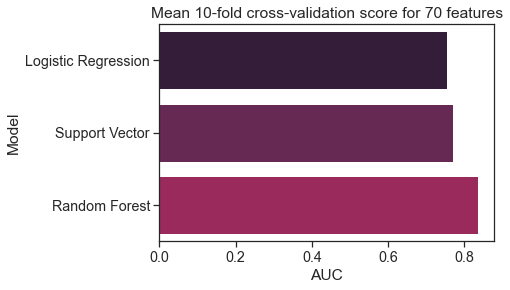

In [38]:
# sns.set(style=("ticks"), font_scale=1.5)
sns.set_palette("rocket")
ax = sns.barplot(x="AUC", y="Model", data=df, ).set_title('Mean 10-fold cross-validation score for 70 features')


## Testing how significant features are 

In [39]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
        'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred']

features_categorical = ['PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD']

sol = df_train[df_train["Binary_Solubility"] == 1]
non_sol = df_train[df_train["Binary_Solubility"] == 0]

## Mann-Whitney U test 

In [40]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(sol[feature], non_sol[feature]) # function returns statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [41]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [42]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

F p=0.00000
V p=0.00000
L p=0.00000
C p=0.00000
S p=0.00000
P p=0.00000
T p=0.00000
Y p=0.00000
Gravy p=0.00000
hydr_count p=0.00000
G p=0.00000
I p=0.00000
H p=0.00000
disorder p=0.00000
A p=0.00000
W p=0.00000
Aggregation_propensity p=0.00000
Q p=0.00000
M p=0.00000
D p=0.00000
R p=0.00000
N p=0.00000
Aromaticity p=0.00000
sheet p=0.00000
Hydrophobic_exposed p=0.00000
polar_count p=0.00000
turn p=0.00000
R_exposed p=0.00000
L_exposed p=0.00000
K p=0.00000
Polar_exposed p=0.00000
E p=0.00000
V_exposed p=0.00001
I_exposed p=0.00009
D_exposed p=0.00016
A_exposed p=0.00017
F_exposed p=0.00034
charge_at_5 p=0.00035
molecular_weight p=0.00223
H_exposed p=0.00242
length p=0.00297
E_exposed p=0.00419
M_exposed p=0.00519
S_exposed p=0.01023
isoelectric_point p=0.01393
Y_exposed p=0.03809
N_exposed p=0.04439
Q_exposed p=0.08066
helix p=0.10200
rhsa_netsurfp2 p=0.10234
LHPpred p=0.10838
K_exposed p=0.20203
C_exposed p=0.22852
thsa_netsurfp2 p=0.24376
charge_at_7 p=0.31204
tasa_netsurfp2 p=0.322

## Fishers Exact test

In [43]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(sol[feature]) 
    B = len(sol[feature]) - sum(sol[feature]) 
    C = sum(non_sol[feature]) 
    D = len(non_sol[feature]) - sum(non_sol[feature])
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function returns odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')


In [44]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [45]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))


SUMOylation_MSD p=0.07026
Acetylation_MSD p=0.08989
PTM_MSD p=0.22478
Palmitoylation_MSD p=0.33116
Glycosylation_MSD p=0.49199
Phosphorylation_MSD p=0.73476
Ubiquitination_MSD p=0.73476
Methylation_MSD p=0.73476


In [46]:
sns.set(style=("ticks"), font_scale=4)
x1, x2= 0, 1
dataset = new_df
labels = ['Soluble',"Non-Soluble"]

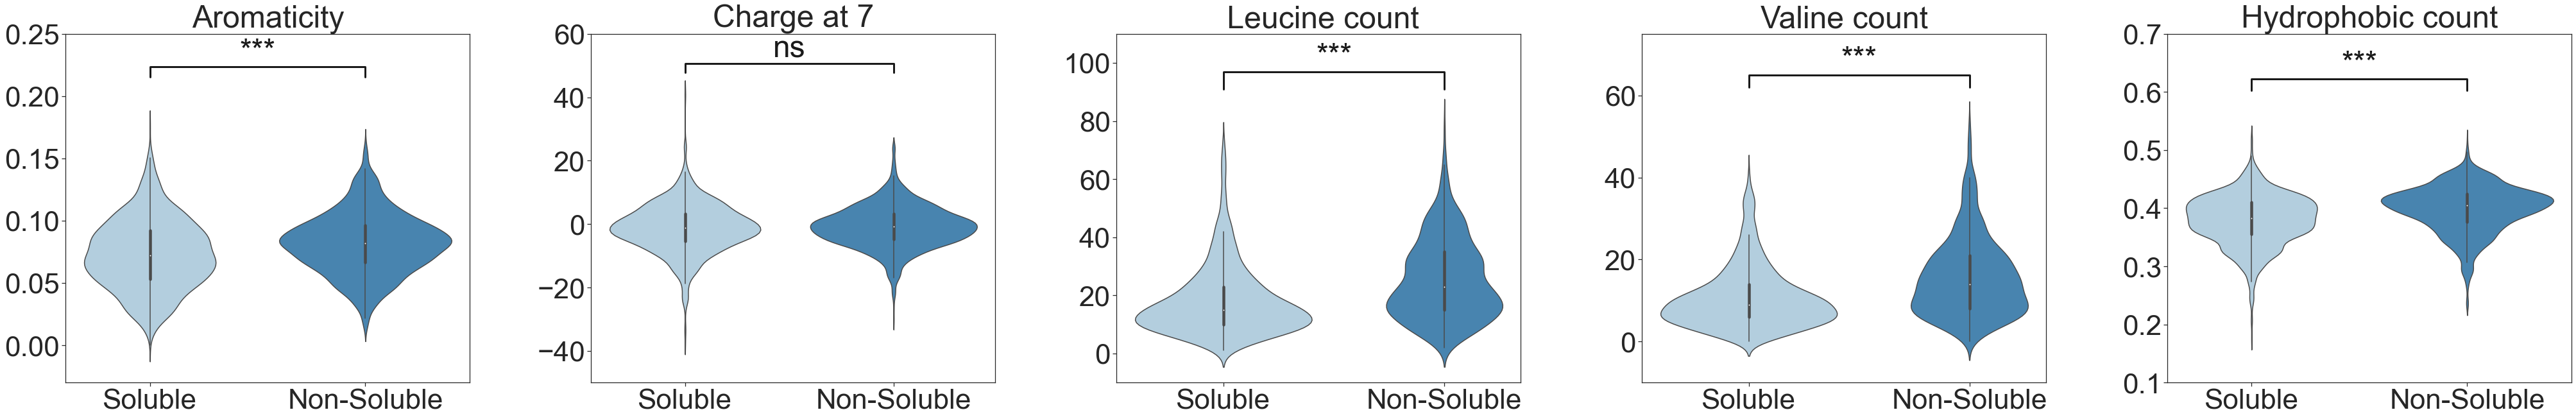

In [47]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False, figsize=(70, 10))

sns.violinplot(x="Binary_Solubility", y="Aromaticity", data=dataset, ax=ax1, order=[1, 0], palette="Blues")
ax1.set(ylabel=None, xlabel=None, title="Aromaticity", xticklabels=(labels),ylim=(-0.03,0.25))
y, h, col = dataset["Aromaticity"].max() + 0.04, 0.008, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_Solubility", y="charge_at_7", data=dataset, ax=ax2, order=[1, 0], palette="Blues")
ax2.set(ylabel=None, xlabel=None, title="Charge at 7", xticklabels=(labels), ylim=(-50,60))
y, h, col = dataset["charge_at_7"].max() + 6, 3, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax2.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_Solubility", y="L", data=dataset, ax=ax3, order=[1, 0], palette="Blues")
ax3.set(ylabel=None, xlabel=None, title=" Leucine count", xticklabels=(labels), ylim=(-10,110) )
y, h, col = dataset["L"].max() + 10, 6, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


sns.violinplot(x="Binary_Solubility", y="V", data=dataset, ax=ax4, order=[1, 0], palette="Blues")
ax4.set(ylabel=None, xlabel=None, title="Valine count", xticklabels=(labels),ylim=(-10,75))
y, h, col = dataset["V"].max() + 8, 3, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


sns.violinplot(x="Binary_Solubility", y="hydr_count", data=dataset, ax=ax5, order=[1, 0], palette="Blues")
ax5.set(ylabel=None, xlabel=None, title="Hydrophobic count", xticklabels=(labels),ylim=(0.1,0.7))
y, h, col = dataset["hydr_count"].max() + 0.08, 0.02, 'k'
ax5.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax5.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


plt.savefig('Figures/ViolinPlots.png', dpi=300, bbox_inches='tight')
plt.subplots_adjust(wspace = 0.3)
plt.show()


## Feature correlation

In [48]:
# calculate pairwise correlation
corr_all = new_df.corr()

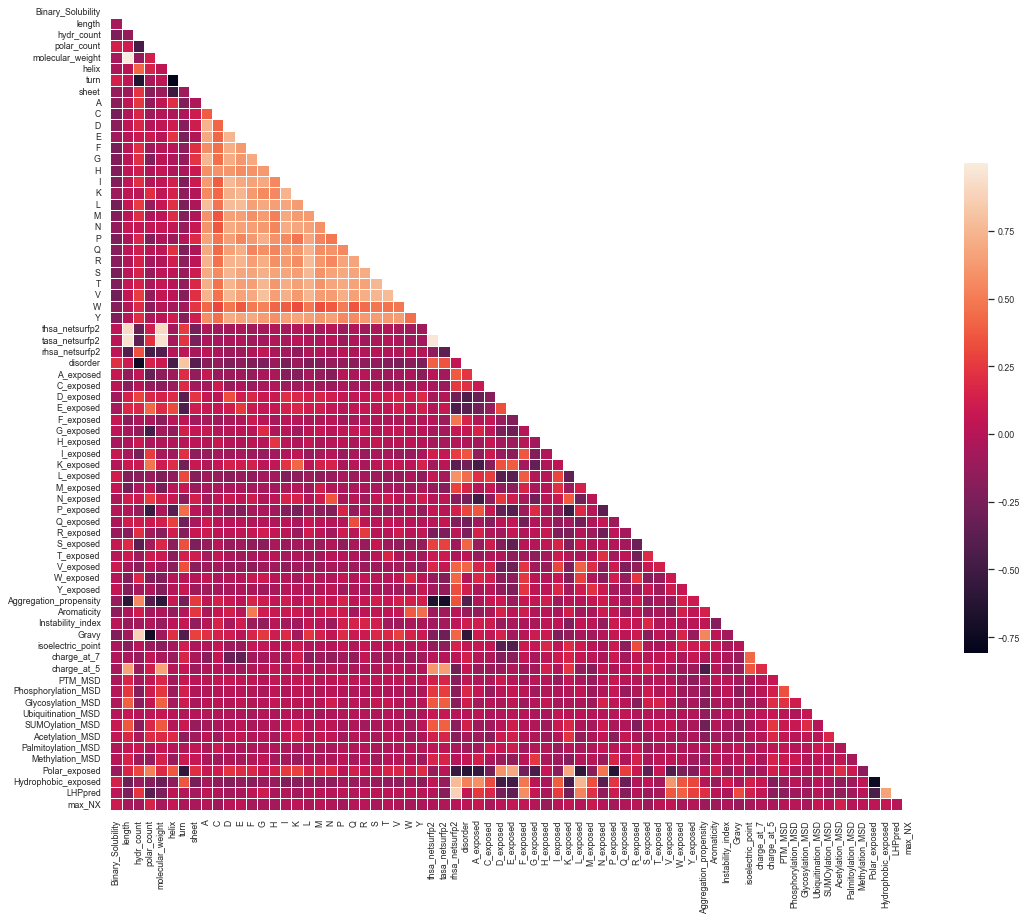

In [49]:
sns.set(font_scale=0.8)

mask = np.triu(np.ones_like(corr_all, dtype=bool))
sns.set_style(style = 'white')
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_all, mask=mask, cmap="rocket", square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);
plt.savefig('Figures/Correlations.png', dpi=300, bbox_inches='tight')


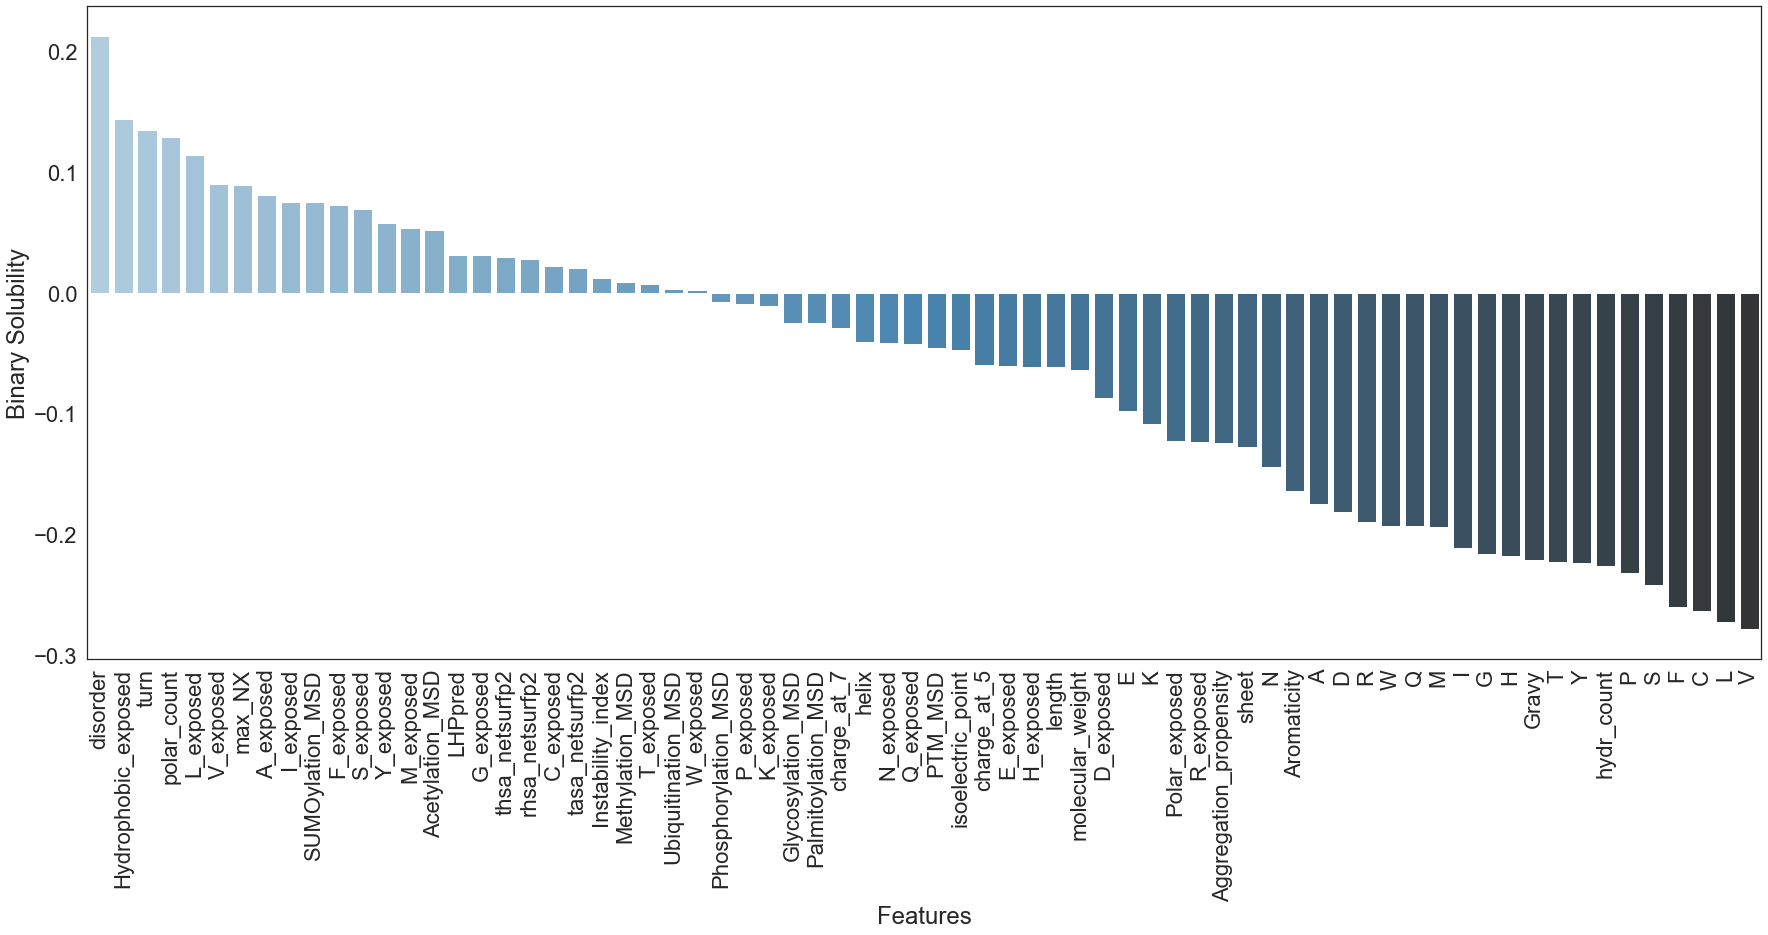

In [68]:
sns.set(style=("white"), font_scale=2)
sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
correlations_all = corr_all[["Binary_Solubility"]].sort_values(by="Binary_Solubility", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["Binary_Solubility"]]

fig = plt.figure(figsize=(30, 12)) 
sns.barplot(x="index", y="Binary_Solubility", data=correlations_all, palette="Blues_d")
plt.xlabel("Features") 
plt.ylabel("Binary Solubility") 
plt.xticks(rotation=90)
plt.savefig('Figures/featureCorrelation.png', dpi=300, bbox_inches='tight')

## Redoing everything with only top 20 features:

In [51]:
top_20 = top_20["feature"].tolist()
top_20.append("Binary_Solubility")
new_df_top20 =original[top_20]

Final_DNASU_ML_top20 = get_normalised_df(new_df_top20)#TRAINING DATASET
df_train_top20, df_test_val_top20 = train_test_split(Final_DNASU_ML_top20, test_size=0.2)
df_test_top20, df_val_top20 = train_test_split(df_test_val_top20, test_size=0.5)
df_train_top20 =df_train_top20.reset_index(drop=True)
df_test_top20 = df_test_top20.reset_index(drop=True)
df_val_top20 = df_val_top20.reset_index(drop=True)


In [52]:
#Labels are the values to be predicted, in this case the solubility
Train_labels_top20 = np.array(df_train_top20['Binary_Solubility'])

# Remove the labels from the features
Train_features_top20= df_train_top20.drop('Binary_Solubility', axis = 1)

# Saving feature names for later use
Train_feature_list_top20 = list(Train_features_top20.columns)

# Convert to numpy array
Train_features_top20 = np.array(Train_features_top20)
# Train_features = RobustScaler().fit_transform(Train_features)


#Same thing for test set
Test_labels_top20 = np.array(df_test_top20['Binary_Solubility'])
Test_features_top20 = df_test_top20.drop('Binary_Solubility', axis = 1)
Test_feature_list_top20 = list(Test_features_top20.columns)
Test_features_top20 = np.array(Test_features_top20)
# Test_features = RobustScaler().fit_transform(Test_features)

#And the cleaned test set
Test_labels2_top20 = np.array(df_val_top20['Binary_Solubility'])
Test_features2_top20 = df_val_top20.drop('Binary_Solubility', axis = 1)
Test_feature_list2_top20 = list(Test_features2_top20.columns)
Test_features2_top20 = np.array(Test_features2_top20)
# Test_features2 = RobustScaler().fit_transform(Test_features2)

#Check shape of train and test
print('Training Features Shape:', Train_features_top20.shape)
print('Training Labels Shape:', Train_labels_top20.shape)
print('Testing Features Shape:', Test_features_top20.shape)
print('Testing Labels Shape:', Test_labels_top20.shape)
print('Cleaned testing Features Shape:', Test_features2_top20.shape)
print('Cleaned testing Labels Shape:', Test_labels2_top20.shape)


Training Features Shape: (2252, 50)
Training Labels Shape: (2252,)
Testing Features Shape: (282, 50)
Testing Labels Shape: (282,)
Cleaned testing Features Shape: (282, 50)
Cleaned testing Labels Shape: (282,)


In [53]:
#Support vector
svc_top20 = SVC(random_state=42)
svc_top20.fit(Train_features_top20, Train_labels_top20)

#random forest
rf_top20 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt')
rf_top20.fit(Train_features_top20, Train_labels_top20)

#Logistic regression
lr_top20 = LogisticRegression(max_iter = 1000)
lr_top20.fit(Train_features_top20, Train_labels_top20)

LogisticRegression(max_iter=1000)

In [54]:
# Use the forest's predict method on the test data
rf_predictions_top20 = rf_top20.predict(Test_features_top20)

# Probabilities for each class
rf_probs_top20 = rf_top20.predict_proba(Test_features_top20)[:, 1]

#same for cleaned test set
rf_predictions2_top20 = rf_top20.predict(Test_features2_top20)
rf_probs2_top20 = rf_top20.predict_proba(Test_features2_top20)[:, 1]

In [55]:
# Calculate roc auc 
roc_value = roc_auc_score(Test_labels_top20, rf_probs)
print('AUC:', roc_value)

#same for cleaned
roc_value = roc_auc_score(Test_labels2_top20, rf_probs2)
print('AUC:', roc_value)

AUC: 0.531489081420682
AUC: 0.5043118936399569


In [56]:
# Extract feature importances
fi_top20 = pd.DataFrame({'feature': (Train_feature_list_top20),
                   'importance': rf_top20.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi_top20

,feature,importance
49,G,0.061480
47,D,0.056623
45,Y,0.050662
33,N,0.042022
28,M,0.041360
37,H,0.037472
44,polar_count,0.032417
29,A_exposed,0.026300
43,sheet,0.026129
46,R_exposed,0.025310


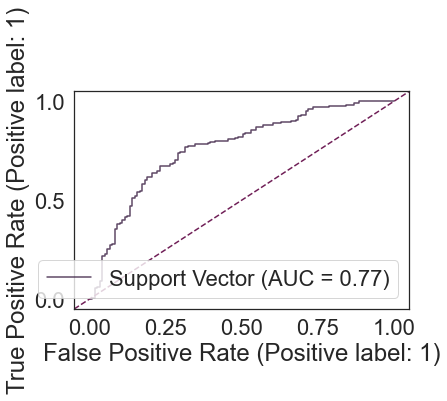

In [57]:
sns.set_palette("rocket")
ax = plt.gca()
svc_disp2 = plot_roc_curve(svc_top20, Test_features2_top20, Test_labels2_top20,name='Support Vector', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

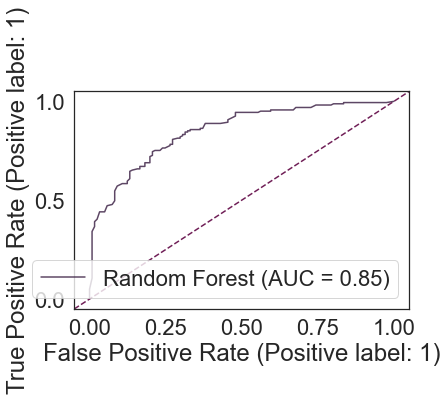

In [58]:
ax = plt.gca()
rf_disp2 = plot_roc_curve(rf_top20, Test_features2_top20, Test_labels2_top20,name='Random Forest', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

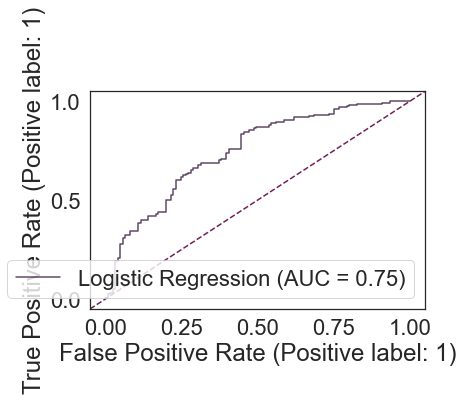

In [59]:
ax = plt.gca()
svc_disp2 = plot_roc_curve(lr_top20, Test_features2_top20, Test_labels2_top20,name='Logistic Regression', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

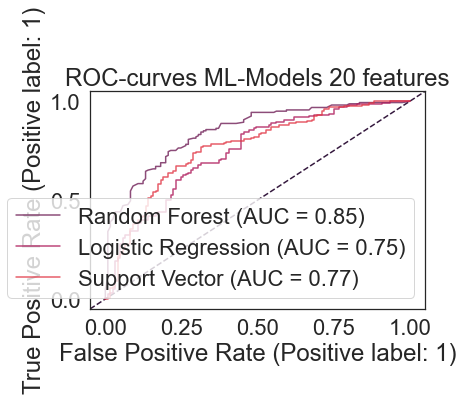

In [60]:
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf_top20, Test_features2_top20, Test_labels2_top20,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr_top20, Test_features2_top20, Test_labels2_top20,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc_top20, Test_features2_top20, Test_labels2_top20,name='Support Vector', ax=ax, alpha=0.8)
plt.title('ROC-curves ML-Models 20 features')
plt.show()

In [61]:
from sklearn.model_selection import train_test_split
SOLtarget = np.array(df_train['Binary_Solubility'])
SOLdata = np.array(Train_features)

In [62]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 10)

In [63]:
AUC_rf = []
for train_index,test_index in kf.split(SOLdata, SOLtarget):
    x_train, x_test, y_train, y_test = SOLdata[train_index], SOLdata[test_index], \
                                        SOLtarget[train_index], SOLtarget[test_index]
    model = LogisticRegression(max_iter = 1000)
    AUC_rf.append(get_AUC(model, x_train, x_test, y_train, y_test))
print("Mean AUC score:")
print(np.mean(AUC_rf))

Mean AUC score:
0.7432304934552436


In [64]:
print(np.mean(cross_val_score(LogisticRegression(max_iter = 1000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))

0.7432304934552436
0.7590482268379051
0.8243325956168632


In [65]:
# LR2 = cross_val_score(LogisticRegression(max_iter = 10000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# SVM2 = cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# RF2 = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)

# mean_LR2 = np.mean(LR)
# mean_SVM2 = np.mean(SVM)
# mean_RF2 = np.mean(RF)

# std_LR2 = np.std(LR)
# std_SVM2 = np.std(SVM)
# std_RF2 = np.std(RF)


# labels = ['Logistic Regression', 'Support Vector Machine', 'Random Forest']
# x_pos = [1,2,3]

# means2 = [mean_LR2, mean_SVM2, mean_RF2]
# stds2 = [std_LR2, std_SVM2, std_RF2]

# fig, ax = plt.subplots()
# ax.bar(x_pos, means2, yerr=stds2, align='center', ecolor='black',alpha = 0.5, capsize=15, color="purple")
# ax.set_xticks(x_pos)
# ax.set_xticklabels(labels)
# ax.set_title("10-fold cross-validation")
# ax.yaxis.grid(True)
# plt.savefig('Figures/10FoldBarplot2.png', dpi=300, bbox_inches='tight')


NameError: name 'LR' is not defined

In [ ]:
labels = ['LR', 'SVM','RF', 'LR_top20','SVM_top20','RF_top20']

means3 = [mean_LR, mean_SVM,mean_RF, mean_LR2,mean_SVM2,mean_RF2]
stds3 = [std_LR, std_SVM, std_RF,std_LR2, std_SVM2, std_RF2]
x_pos = [1, 1.8, 2.6, 4,4.8 ,5.6]
colors= ["lightblue","blue", "darkblue","plum", "violet","purple"]
fig, ax = plt.subplots()
ax.bar(x_pos, means3, yerr=stds3, align='center', ecolor='black',alpha = 0.6, capsize=15, color=colors)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("10-fold cross-validation")
ax.yaxis.grid(True)
plt.savefig('Figures/10FoldBarplot3.png', dpi=300, bbox_inches='tight')




In [ ]:
d = {'Model': ['Logistic Regression', 
                   'Support Vector', 'Random Forest'],
        'AUC':[0.7579517511407079, 0.7778397063227807, 0.8449512028081674]}
df = pd.DataFrame(data=d)

In [ ]:
# sns.set(style=("ticks"), font_scale=1.5)
sns.set_palette("rocket")
ax = sns.barplot(x="AUC", y="Model", data=df, ).set_title('Mean 10-fold cross-validation score for 20 features')